# Dubinska analiza podataka - projektni zadatak

## 1. Predprocesiranje podataka

In [2]:
# Ovo je tu jer ponekad zna prvu liniju u svakoj čeliji označit kao grešku makar sve radi,
# ali me živcira to podcrtano. Pa treba ovo pokrenut, pa se od VS coda izbaci da se treba
# instalirati 'languagepack' pa onda zatvorit i opet otvorit .ipynb file i nema više podcrtanog

# lintr::use_lintr(type = "tidyverse")

In [74]:
library(tidyr)
library(dplyr)
library(neuralnet)
library(caret)

In [116]:
phoneData <- read.csv('phone_specs.csv')

str(phoneData)

'data.frame':	1359 obs. of  22 variables:
 $ Index          : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Name           : chr  "OnePlus 7T Pro McLaren Edition" "Realme X2 Pro" "iPhone 11 Pro Max" "iPhone 11" ...
 $ Brand          : chr  "OnePlus" "Realme" "Apple" "Apple" ...
 $ Model          : chr  "7T Pro McLaren Edition" "X2 Pro" "iPhone 11 Pro Max" "iPhone 11" ...
 $ BatteryCapacity: int  4085 4000 3969 3110 4000 3800 4085 4300 6000 4000 ...
 $ ScreenSize     : num  6.67 6.5 6.5 6.1 6.4 6.55 6.67 6.8 6.59 6.39 ...
 $ Touchscreen    : chr  "Yes" "Yes" "Yes" "Yes" ...
 $ ResolutionX    : int  1440 1080 1242 828 1080 1080 1440 1440 1080 1080 ...
 $ ResolutionY    : int  3120 2400 2688 1792 2340 2400 3120 3040 2340 2340 ...
 $ Processor      : int  8 8 6 6 8 8 8 8 8 8 ...
 $ RAM            : int  12000 6000 4000 4000 6000 8000 8000 12000 8000 6000 ...
 $ InternalStorage: num  256 64 64 64 128 128 256 256 128 128 ...
 $ RearCamera     : num  48 64 12 12 12 48 48 12 48 48 ...
 $ FrontCamera    : nu

In [117]:
table(phoneData$OS)


   Android BlackBerry   Cyanogen        iOS   Sailfish      Tizen    Windows 
      1299         10         10         17          1          3         19 

In [118]:
phoneData <- phoneData %>%
    filter(!(OS == 'Sailfish' | OS == 'Tizen')) %>%                       # delete rows with less know OS (only 3 rows) because One-hot-encoding
    mutate(value = 1) %>% spread(OS, value,  fill = 0 ) %>%               # One-hot-encoding OS column
    mutate(across(c(Touchscreen, WiFi, Bluetooth, GPS, X3G, X4G.LTE),
    ~as.numeric(ifelse(.x == 'Yes', 1, 0)))) %>%                          # convert categorical Yes/No to 1/0 
    mutate(Price = round(Price / 87.95)) %>%                              # convert price (indian rupee to euro)
    mutate(PriceCategory = ifelse(Price <= 200, 'Low-End',
                           ifelse(Price <= 500, 'Mid-Range', 'High-End'))) %>%      # Defining price categories
    filter(!(PriceCategory == 'Low-End' & RearCamera >= 20)) %>%
    filter(!(PriceCategory == 'Low-End' & FrontCamera >= 10)) %>%
    filter(!(PriceCategory == 'Low-End' & RAM > 4000)) %>%
    filter(!(PriceCategory == 'Low-End' & InternalStorage > 64)) %>%          # Filtering some data to get better accuracy
    mutate(across(c(5, 6, 8:14, 18), scale))                              # normalization with scale() for numeric data

In [119]:
names(phoneData)

[1] "Index"           "Name"            "Brand"           "Model"          
 [5] "BatteryCapacity" "ScreenSize"      "Touchscreen"     "ResolutionX"    
 [9] "ResolutionY"     "Processor"       "RAM"             "InternalStorage"
[13] "RearCamera"      "FrontCamera"     "WiFi"            "Bluetooth"      
[17] "GPS"             "SIMsNumber"      "X3G"             "X4G.LTE"        
[21] "Price"           "Android"         "BlackBerry"      "Cyanogen"       
[25] "iOS"             "Windows"         "PriceCategory"

In [120]:
# Removing columns that are not used for traning (Index, Name, Brand, Model and Price)
phoneData <- phoneData[-c(1:4, 21)]

In [121]:
table(phoneData$PriceCategory)


 High-End   Low-End Mid-Range 
       49       977       144 

## 2. Klasifikacija - umjetne neuronske mreže

In [122]:
# First ANN model with neuralnet package
set.seed(123)

trainIndex = createDataPartition(phoneData$PriceCategory, p = 0.75, list = FALSE)
trainData <- phoneData[trainIndex, ]
testData <- phoneData[-trainIndex, ] 

nn = neuralnet(PriceCategory ~ .,
                data = trainData,
                hidden = 14,
                lifesign = 'full',
                linear.output = FALSE)

hidden: 14    thresh: 0.01    rep: 1/1    steps: 
   1000	min thresh: 0.0996231409036611
                                                 
   2000	min thresh: 0.0546513793901923
                                                 
   3000	min thresh: 0.0253587093223993
                                                 
   4000	min thresh: 0.0108831842964161
                                                 
   4092
	error: 14.20329
	time: 11.7 secs



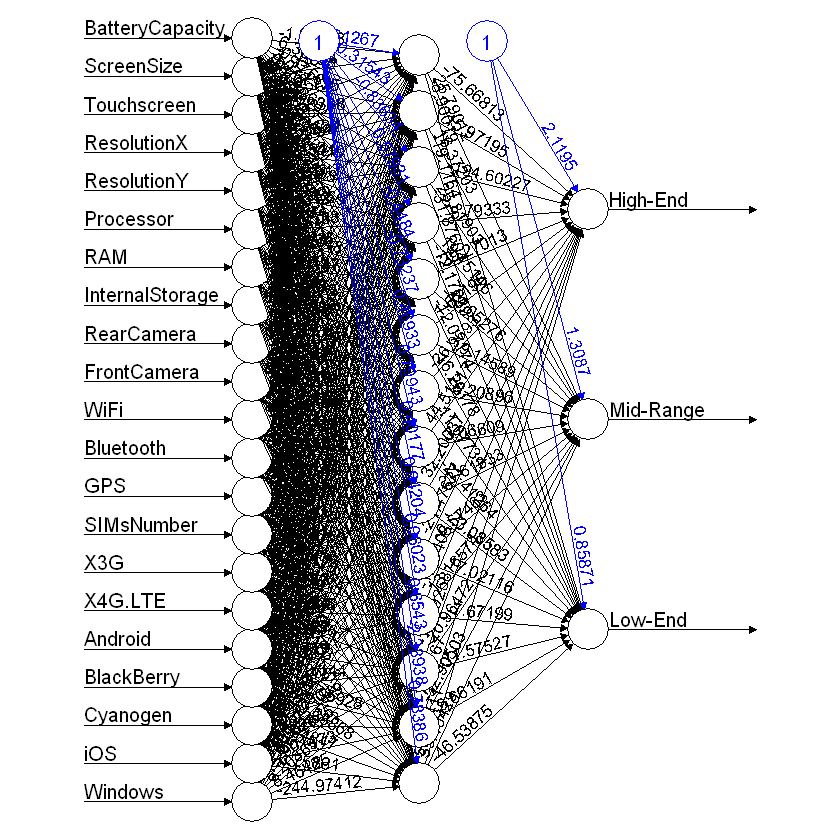

In [123]:
plot(nn, rep=1)

In [126]:
predictions <- neuralnet::compute(nn, rep = 1, testData[, -23])

pred <- predictions$net.result

pred <- data.frame("pred" = ifelse(max.col(pred[ ,1:3]) == 1, 'High-End',
                            ifelse(max.col(pred[ ,1:3]) == 2, 'Low-End', 'Mid-Range')))

cm <- confusionMatrix(as.factor(testData$PriceCategory), as.factor(pred$pred))
 
print(cm)

Confusion Matrix and Statistics

           Reference
Prediction  High-End Low-End Mid-Range
  High-End         6       2         4
  Low-End          0     240         4
  Mid-Range        8       8        20

Overall Statistics
                                         
               Accuracy : 0.911          
                 95% CI : (0.8723, 0.941)
    No Information Rate : 0.8562         
    P-Value [Acc > NIR] : 0.003237       
                                         
                  Kappa : 0.6712         
                                         
 Mcnemar's Test P-Value : 0.197897       

Statistics by Class:

                     Class: High-End Class: Low-End Class: Mid-Range
Sensitivity                  0.42857         0.9600          0.71429
Specificity                  0.97842         0.9048          0.93939
Pos Pred Value               0.50000         0.9836          0.55556
Neg Pred Value               0.97143         0.7917          0.96875
Prevalence              

In [145]:
# Second ANN model with train() function
set.seed(1)

train_index <- createFolds(trainData$PriceCategory, k = 10)

nnetFit <- phoneData %>% train(PriceCategory ~ .,
  method = "nnet",
  data = .,
  tuneLength = 5,
  trControl = trainControl(method = "cv", indexOut = train_index),
  trace = FALSE)
nnetFit

Neural Network 

1170 samples
  21 predictor
   3 classes: 'High-End', 'Low-End', 'Mid-Range' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1052, 1052, 1053, 1054, 1054, 1052, ... 
Resampling results across tuning parameters:

  size  decay  Accuracy   Kappa    
  1     0e+00  0.8884726  0.6709041
  1     1e-04  0.8760237  0.5611517
  1     1e-03  0.8792644  0.6254778
  1     1e-02  0.8781536  0.6244270
  1     1e-01  0.8792899  0.6195292
  3     0e+00  0.9007929  0.7061318
  3     1e-04  0.9078186  0.7347591
  3     1e-03  0.9111627  0.7375155
  3     1e-02  0.9156699  0.7424988
  3     1e-01  0.9133847  0.7329313
  5     0e+00  0.9396905  0.8014908
  5     1e-04  0.9339306  0.8019521
  5     1e-03  0.9282880  0.7814341
  5     1e-02  0.9407497  0.8236120
  5     1e-01  0.9339571  0.7997686
  7     0e+00  0.9373537  0.8034415
  7     1e-04  0.9396775  0.8214573
  7     1e-03  0.9519973  0.8587739
  7     1e-02  0.9441852  0.8330079
  7     1e-01  

In [146]:
pr <- predict(nnetFit, testData)
confusionMatrix(pr, reference = as.factor(testData$PriceCategory))

Confusion Matrix and Statistics

           Reference
Prediction  High-End Low-End Mid-Range
  High-End         9       0         2
  Low-End          2     242         2
  Mid-Range        1       2        32

Overall Statistics
                                          
               Accuracy : 0.9692          
                 95% CI : (0.9423, 0.9858)
    No Information Rate : 0.8356          
    P-Value [Acc > NIR] : 3.31e-13        
                                          
                  Kappa : 0.8898          
                                          
 Mcnemar's Test P-Value : 0.5062          

Statistics by Class:

                     Class: High-End Class: Low-End Class: Mid-Range
Sensitivity                  0.75000         0.9918           0.8889
Specificity                  0.99286         0.9167           0.9883
Pos Pred Value               0.81818         0.9837           0.9143
Neg Pred Value               0.98932         0.9565           0.9844
Prevalence     

## 3. Ansambli - slučajne šume

## 4. Asocijacijska analiza - učenje asocijacijskih pravila

## 5. Grupiranje k-sredina